In [ ]:
import nltk
import pandas as pd 
import ast
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

Now on to tokenization. Let us get an idea of how many words we will be dealing with . It will give us a much better idea of what vocabulary size we are working with

In [ ]:
df = pd.read_csv("feature_engineered.csv")
df["text_split"] = df.text_split.apply(lambda x: ast.literal_eval(x))
del df['Unnamed: 0']


In [ ]:
df

,textID,text,selected_text,sentiment,text_split,selected_text_split,initial_indice,final_indice
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"[id, have, responded, if, i, were, going]","['id', 'have', 'responded', 'if', 'i', 'were',...",0,6
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,"[soon, sad, i, will, miss, you, here, in, san,...","['soon', 'sad']",0,1
2,088c60f138,my boss is bullying me...,bullying me,negative,"[my, boss, is, bullying, me]","['bullying', 'me']",3,4
3,9642c003ef,what interview! leave me alone,leave me alone,negative,"[what, interview, leave, me, alone]","['leave', 'me', 'alone']",2,4
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"[sons, of, <curse>, why, couldnt, they, put, t...","['sons', 'of', '<curse>']",0,2
5,50e14c0bb8,Soooo high,Soooo high,neutral,"[soon, high]","['soon', 'high']",0,1
6,e050245fbd,Both of you,Both of you,neutral,"[both, of, you]","['both', 'of', 'you']",0,2
7,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,"[journey, wow, u, just, became, cooler, here, ...","['wow', 'u', 'just', 'became', 'cooler']",1,5
8,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,"[as, much, as, i, love, to, be, hopeful, i, re...","['as', 'much', 'as', 'i', 'love', 'to', 'be', ...",0,22
9,bbe3cbf620,test test from the LG enV2,test test from the LG enV2,neutral,"[test, test, from, the, lg, env<num>]","['test', 'test', 'from', 'the', 'lg', 'env<num>']",0,5


We will somewhat crudely exclude punctuation for ease of visualization

In [ ]:
nltk.download('punkt')
text = []
for word_list in df.text_split:
    text.extend(word_list)
text = [word for word in text if word.isalnum()]


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


The code above is putting every word from the tweets into a list and excluding any non alphanumeric characters

In [ ]:
new_text = " ".join(text)
new_text[:50]

'id have responded if i were going soon sad i will '

We know put every word into a single string because nltk's word tokenize function expects a string as input. It will then handle the creation of the word occurance chart

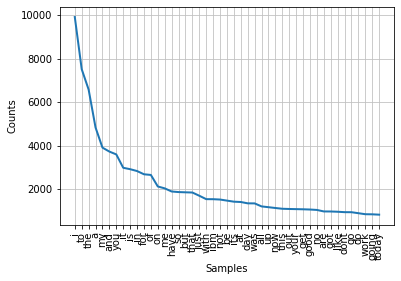

In [ ]:
tknz = nltk.word_tokenize(new_text)
fdist = nltk.FreqDist(tknz)
fdist.plot(45,cumulative=False)

Common words like I, to and the dominate the chart with everthing else rounding out at 2000 occurences or below. This helps inform what the size of the tokenization dictionary should be.

Time to tokenize the text corpus

In [ ]:
tokenizer = Tokenizer(num_words=20000,oov_token="<OOV>")
tokenizer.fit_on_texts(df.text_split)
tokenized_text = tokenizer.texts_to_sequences(df.text_split)
tokenized_selected_text = tokenizer.texts_to_sequences(df.selected_text_split)
len(tokenizer.word_index)

19549

In [ ]:
tokenizer.word_index["bullying"]

8253

There are 19549 words in our corpus and we will use the most common 15,000 for our model

In [ ]:
pad_token_text = pad_sequences(tokenized_text,padding = "post")

Now that the text is padded and tokenized we can prepare a model!

In [ ]:
pad_token_text[0]

array([ 320,   17, 8251,   68,    2,  122,   46,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

Padding by default pads to the length of the longest Tweet. To make the score better we might experiment with different padding lengths and with pre vs post padding but this will suffice for now

In [ ]:
pd.DataFrame(pad_token_text).to_csv("../Modeling/pad_token_text.csv",header=None,index=None)
df.to_csv("../Modeling/tokenized.csv",index=None)

In [ ]:
with open('../kaggle_test_preparation/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)